<a href="https://colab.research.google.com/github/nvacharya2/MiniUnit/blob/master/Deep_Dream_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepDreaming with TensorFlow

### ___Alex Mordvintsev___

This notebook produces DeepDream images from user-supplied photos using Google's pretrained Inception neural network. It can be used as a starting point for further exploration in visualizing convolutional neural networks.

### 1) Load the model graph

The pretrained Inception network can be downloaded [here](https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip). This next cell downloads the file automatically and unpacks it locally to the Colab kernel. We can the load the contained model file  'tensorflow_inception_graph.pb' in the cell below.

In [11]:
!wget -nc --no-check-certificate https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip
!wget -nc https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg

file_contents = open("YellowLabradorLooking_new.jpg").read()  

from io import BytesIO
from IPython.display import clear_output, Image, display
import numpy as np
import PIL.Image
import tensorflow as tf
from __future__ import print_function

model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

File ‘inception5h.zip’ already there; not retrieving.

Archive:  inception5h.zip
File ‘YellowLabradorLooking_new.jpg’ already there; not retrieving.



/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### Optional: Upload an image from your computer

# Skip these steps if you just want to run this example

In [12]:
from google.colab import files
uploaded = files.upload()

Saving Photo on 12-10-19 at 7.47 PM.jpg to Photo on 12-10-19 at 7.47 PM.jpg


In [0]:

if type(uploaded) is not dict: uploaded = uploaded.files  ## Deal with filedit versions
file_contents = uploaded[uploaded.keys()[0]]

### 2) Load the starting image 

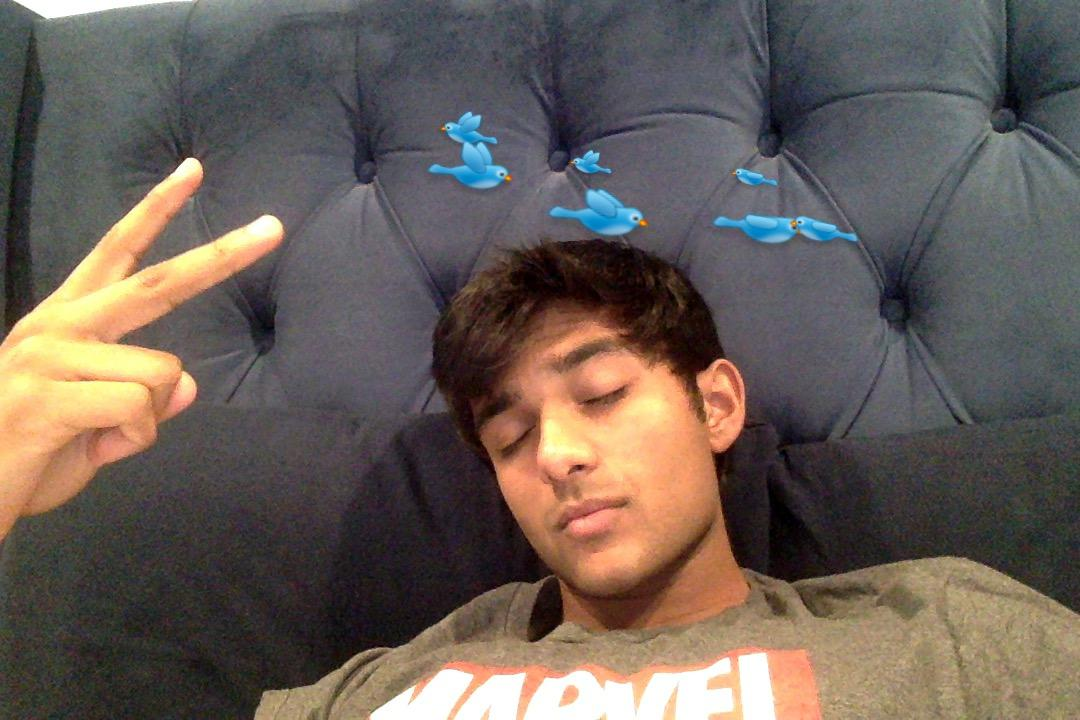

In [15]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
img0 = sess.run(tf.image.decode_image(file_contents))
showarray(img0)

### 4) The core deepdream code

In [0]:
# These parameters let us control the strenth of the deepdream.
octave_n = 4
octave_scale = 1.4
iter_n = 10
strength = 200

# Helper function that uses TensorFlow to resize an image
def resize(img, new_size):
    return sess.run(tf.image.resize_bilinear(img[np.newaxis,:], new_size))[0]

# Apply gradients to an image in a seires of tiles
def calc_grad_tiled(img, t_grad, tile_size=256):
    '''Random shifts are applied to the image to blur tile boundaries over
    multiple iterations.'''
    h, w = img.shape[:2]
    sx, sy = np.random.randint(tile_size, size=2)
    # We randomly roll the image in x and y to avoid seams between tiles.
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-tile_size//2, tile_size),tile_size):
        for x in range(0, max(w-tile_size//2, tile_size),tile_size):
            sub = img_shift[y:y+tile_size,x:x+tile_size]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+tile_size,x:x+tile_size] = g
    imggrad = np.roll(np.roll(grad, -sx, 1), -sy, 0)
    # Add the image gradient to the image and return the result
    return img + imggrad*(strength * 0.01 / (np.abs(imggrad).mean()+1e-7))

# Applies deepdream at multiple scales
def render_deepdream(t_obj, input_img, show_steps = True):
    # Collapse the optimization objective to a single number (the loss)
    t_score = tf.reduce_mean(t_obj)
    # We need the gradient of the image with respect to the objective
    t_grad = tf.gradients(t_score, t_input)[0]

    # split the image into a number of octaves (laplacian pyramid)
    img = input_img
    octaves = []
    for i in range(octave_n-1):
        lo = resize(img, np.int32(np.float32(img.shape[:2])/octave_scale))
        octaves.append(img-resize(lo, img.shape[:2]))
        img = lo

    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad)
        if show_steps:
            clear_output()
            showarray(img)
    return img

### 4) Let's deep dream !

You can adjust the sliders to change the strength of the deep dream, and how many scales it is applied over.

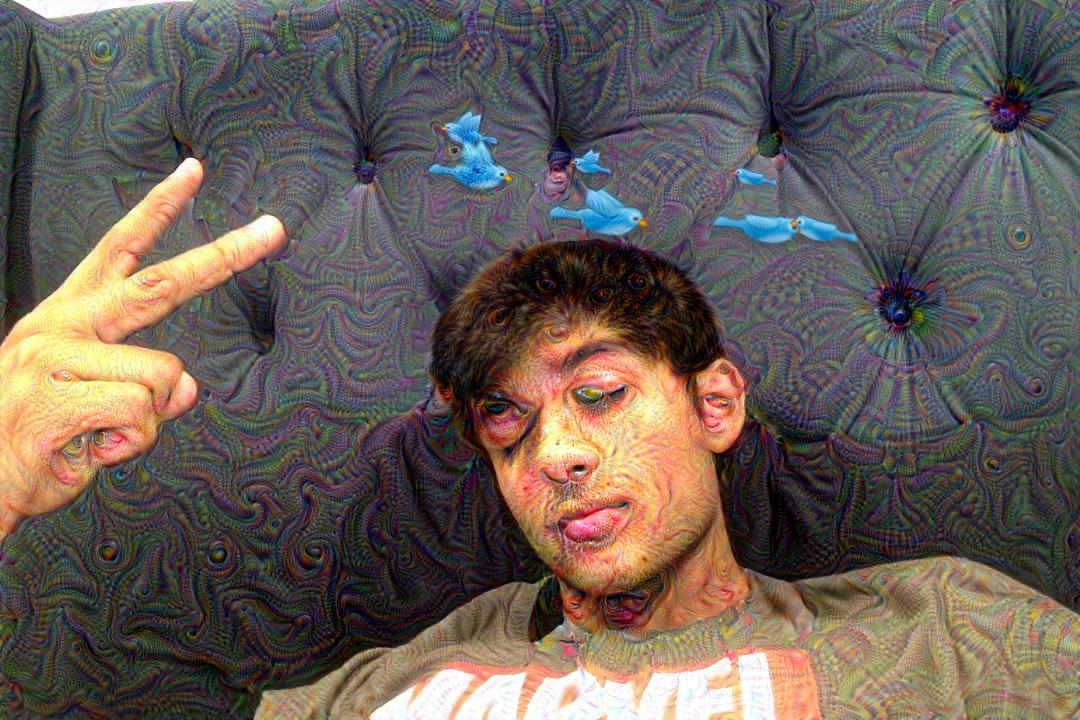

In [17]:
octave_n = 4 #@param {type:"slider", max: 10}
octave_scale = 1.4 #@param {type:"number"}
iter_n = 10 #@param {type:"slider", max: 50}
strength = 200 #@param {type:"slider", max: 1000}
layer = "mixed4c"  #@param ["mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]

final = render_deepdream(tf.square(T(layer)), img0)


### 5) Individual neurons

We can also try and optimize not against an entire layer but just one neuron's activity:

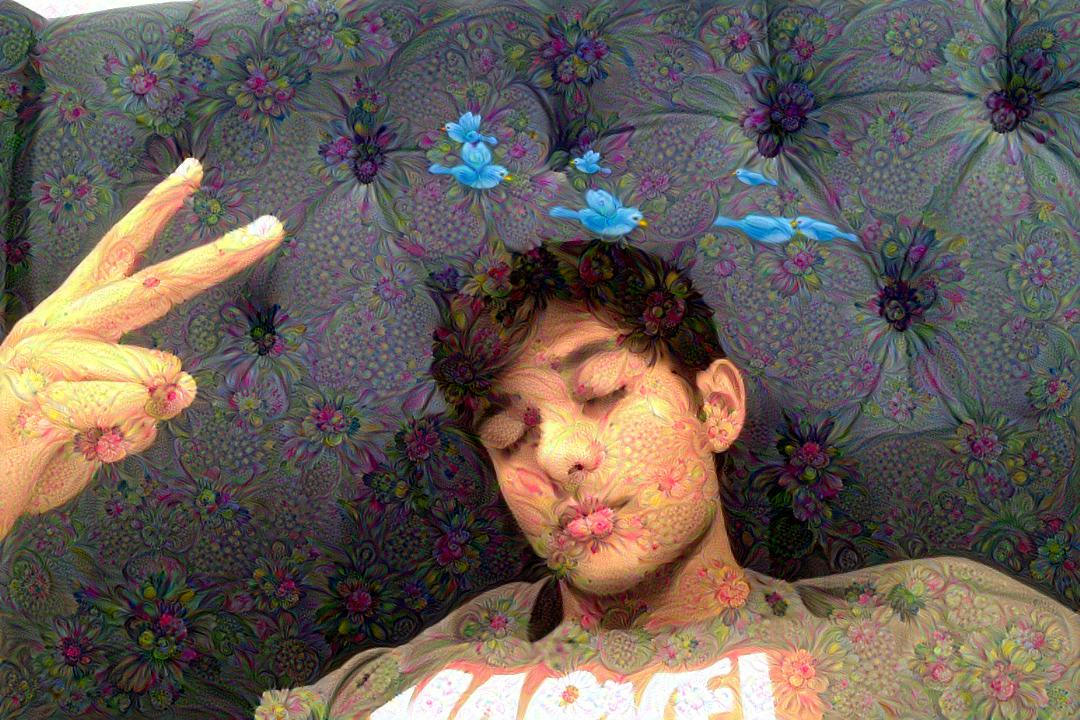

In [18]:
feature_channel = 139 #@param {type:"slider", max: 512}
layer = "mixed4d_3x3_bottleneck_pre_relu"  #@param ["mixed4d_3x3_bottleneck_pre_relu", "mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]
if feature_channel >= T(layer).shape[3]:
  print("Feature channel exceeds size of layer ", layer, " feature space. ")
  print("Choose a smaller channel number.")
else:
  render_deepdream(T(layer)[:,:,:,feature_channel], img0)